# 1. Uniform Timescale

In [0]:
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime
from datetime import timedelta
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans

In [0]:
df = pd.read_csv('20190425_ProcessedTaxiTrajectories.csv')
# Please note that this .csv file should be in the same folder as this .ipynb file.

In [0]:
# Function Process is used to generate the desired 21-dimension xy-location vector of each trip_id i 
# Because this same procedure should be done several thousand times, we warp it as a function to increase the speed
def UniformScale(i, df_i):
    df_i = df_i.reset_index(drop = True)
    ni = len(df_i)
    time_re = np.zeros(ni)   
    for j in range(ni):
        delta = df_i['time'].iloc[j] - df_i['time'].iloc[0]
        time_re[j] = delta.seconds / 60
    # time_re is the column to store the relative time stamps to the first record of the specific trip, unit = minutes
    df_nan = pd.DataFrame({"realtive time": [0],"trip_id": [i],"x": [np.nan],"y": [np.nan]})

    if np.max(time_re) < 100:
        # we discard the trip who don't have records after 100min
        return df_nan
    df_i['relative time'] = time_re
    df_i = df_i[['relative time','trip_id','x','y']] 
    uni_time = 5 * np.arange(0,21)
    # uni_time: the 21 time stamps we need for uniform time scale, 0,5,...,20
    uni_time_miss = list(set(uni_time).difference(time_re))
    n_miss = len(uni_time_miss)
    # uni_time_miss: we would search the time_re series to see if the dataframe df_i has the record at our desired time
    df_miss = pd.DataFrame({"relative time": uni_time_miss,"trip_id": i * np.ones(n_miss)})
    df_i = pd.concat([df_i,df_miss],sort=True)
    df_i = df_i.set_index("relative time")
    df_i = df_i.sort_values(by = 'relative time') 
    df_i = df_i.interpolate(method = 'polynomial',order = 1)
    df_ii = pd.DataFrame(df_i.loc[uni_time])
    df_ii = df_ii.reset_index()
    return df_ii

In [0]:
time = np.array(df['time'])
ng = np.shape(df)[0]
# ng: the number of original GPS records
for i in range(ng):
    time[i] = datetime.strptime(str(time[i]),'%m/%d/%y  %H:%M')
df['time'] = time
# We convert the time string to datetime type for later arithmetic operation
df1 = df.sort_values(by = ['trip_id','time'], ascending = (True, True))
df1 = df1.reset_index(drop = True)

In [0]:
df_scale = pd.DataFrame({"trip_id": [np.nan],"relative time": [np.nan],"x": [np.nan],"y": [np.nan]})
Tid = np.unique(df1['trip_id'])
for i in Tid:
    df_i = pd.DataFrame(df1[df1['trip_id'] == i])
    # df_i is the dataframe which stores the records for trip_id == i 
    df_ii = UniformScale(i,df_i)
    # df_ii: the dataframe which stores the xy-location for trip_id == i && time == [0,5,...,100]
    df_scale = pd.concat([df_scale,df_ii],sort=True)
df_scale = df_scale.iloc[:,1:5].dropna()
df_scale = df_scale.drop_duplicates(subset = ['relative time','trip_id'], keep = 'first')
# df_scale is the dataframe with uniform timescaled records
print('Uniform timescale is done')

Uniform timescale is done


# 2. K-means Clustering

I believe the most appropriate way of doing this section, is to modify the distance function in python-sklearn-KMeans module, as well as the distance function in metrics.silhouette_score. Because the trajectory sample (tensor) distance measurements are different from normal sample(vector) ones. 

Take an intuitive distance evaluation method, the average euclidean distance (Agrawal R, Faloutsos C, Swami A,1993) for example:

\begin{align*}
Eu(R,S) = \sum_{i=1}^n dist(r_{i},s_{i})\\
dist(r_{i},s_{i}) = \sqrt{(r_{i,x}-s_{i,x})^2+(r_{i,y}-s_{i,y})^2}
\end{align*}

where R,S represent two different trajectories, n represents the number of time checkpoints; Eu(R,S) is the euclidean distance between R,S;r_i,s_i are the i-th location record on trajectory R,S;  r_i,x, r_i,y, s_i,x, s_i,y is the x,y location of records r_i, s_i; dist(r_i, s_i) is the euclidean distance between r_i and s_i.

Due to time limits I haven't found any python packet to do such trajectory cluster in k-means directly. Also it's yet uncertain whether the self-defined distance function could convergence decently in k-means, so I tried two other easier methods below: 
* I. For each k in {3,4,...,20}: apply k-means on each of the 21 checkpoints, calculate the corresponding Silhoutte score,and then get the average as the score for cluster number k. This method keeps our original data in shape and have a relative nice Silhoutte score, but it's hard to take this method further into the later Gaussian Mixture Model part. Therefore I continue this task with the follwoing method.

* II. Consider location on different checkpoints on x,y direction as seperate features of a trajectory, flatten our 2 * 21 tensor into 1 * 42 vector:{x_0,x_1,...x_20,y_0,y_1,...y_20}, so our data would be like:

\begin{pmatrix}
x_{0,0} & x_{0,1} & ... & x_{0,20} & y_{0,0} & y_{0,1} & ... & y_{0,20} \\
x_{1,0} & x_{1,1} & ... &          & y_{1,0} & y_{1,1} & ... & y_{1,20} \\
...     &         &     &          &         &         &     &   ...    \\                              
x_{N,0} & x_{N,1} & ... &          &         &         &     & y_{N,20} \\
\end{pmatrix}

where N is the trajectory count. However, 42-dimension may cause some problems in K-means. Therefore, before the K-means, we apply PCA on our dataset with different number of components. Finally we adopt the optimal n-component and k to proceed into Gaussian Mixture Model. 

## 2.1 Average Silhuette on 21 checkpoints

Distance computation in K-means weights each dimension equally and hence care must be taken to ensure that unit of dimension shouldn’t distort relative near-ness of observations. Because K-means is sensitve to variance in data, in the following section, we would normalize the data before fit them into the K-Means model.

In [0]:
n = 21
# n: number of checkpoints
N = (len(df_scale))/ n
# N: number of trajectories we're going to analyze
Tid_scale = np.sort(np.unique(df_scale['trip_id']))
# Tid_scale: the array stores each unique trip_id
print('After uniform timescale processing, we have ' + str(N) + ' trajectories to analyze.')
score_avg = np.zeros(18)
# score: array to store the Silhuette score for clusters k=3,4,...,20

After uniform timescale processing, we have 3623.0 trajectories to analyze.


The optimal cluster number k is: 4, and the corresponding average Silhoutte score is: 0.36386441651850426


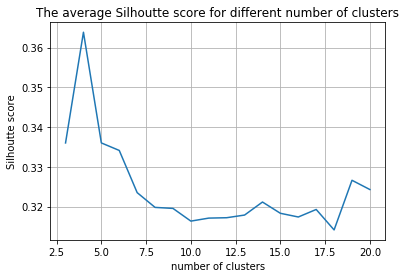

In [0]:
for k in range(3,21):
    s = 0
    # s: to calculate the average Silhoutte score on k
    for i in range(n):
        data_i = np.array(df_scale[df_scale['relative time'] == (i * 5.0)][['x','y']])
        scaler = StandardScaler()
        scaler.fit(data_i)
        data_i = scaler.transform(data_i)
        km = MiniBatchKMeans(n_clusters = k, init = 'k-means++', max_iter = 100)
        km.fit(data_i)
        score_i = metrics.silhouette_score(data_i, km.labels_,metric = 'euclidean')
        s = s + score_i
    score_avg[k - 3] = s / n
print('The optimal cluster number k is: ' + str(np.argmax(score_avg) + 3) +
      ', and the corresponding average Silhoutte score is: ' + str(np.max(score_avg)))
plt.title('The average Silhoutte score for different number of clusters')
plt.plot(np.arange(3,21),score_avg)
plt.grid()
plt.xlabel('number of clusters')
plt.ylabel('Silhoutte score')
plt.show()
# if this code gives "TypeError: 'str' object is not callable' " error, just restart the kernel and it should be fine.

## 2.2 Flatten the tensor into a 42-dimension vector

In [0]:
data_flatten = np.zeros([Tid_scale.shape[0],42])
score_flatten = np.zeros([18,42])
for i,j in enumerate(Tid_scale):
    x_j = np.array(df_scale[df_scale['trip_id'] == j]['x'])
    y_j = np.array(df_scale[df_scale['trip_id'] == j]['y'])
    data_j = np.append(x_j,y_j)
    data_flatten[i,:,] = data_j
# We flatten the samples and save them in data_kmeans. 

The optimal cluster number k is: [3], the optimal number of features is: [1], and the corresponding average Silhoutte score is: 0.516401036960323


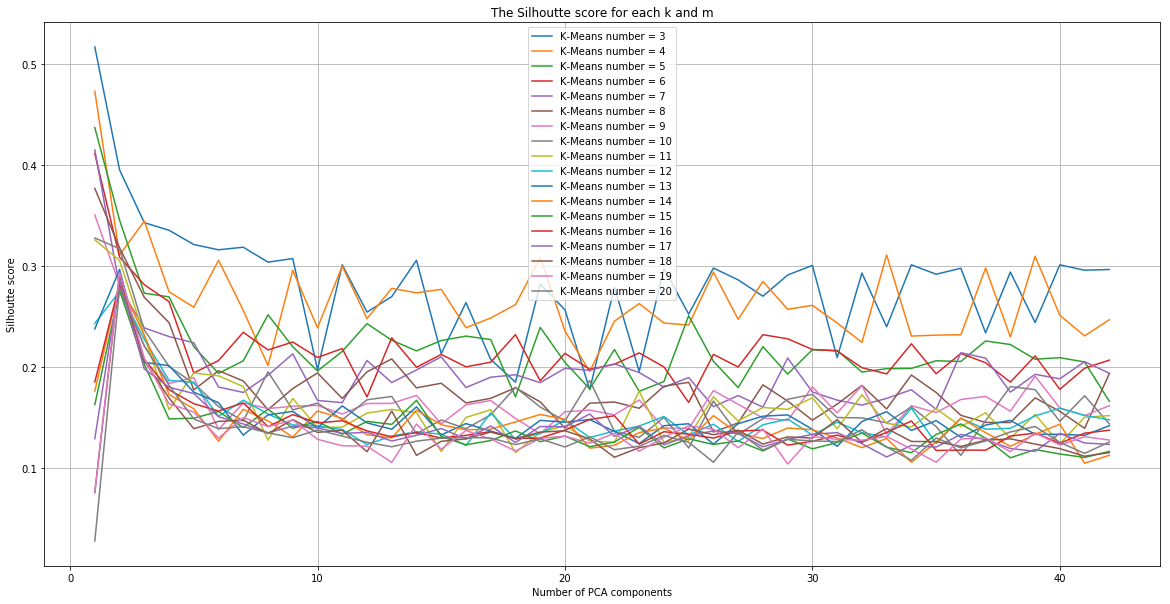

In [0]:
# We use Pipeline to encapsulate our scale-transfrom-cluster process
# First we define the process we'll have in this pipepline: StandardScaler, PCA and MiniBatchKMeans
scaler  = StandardScaler()
pca = PCA()
km = MiniBatchKMeans(init = 'k-means++', max_iter = 100)
pipe = Pipeline(steps = [('scaler',scaler),('pca',pca),('km',km)])
# We next define all the parameters that we want to search over.
ncomp_test = np.arange(1,43) # Values from 1 to 42 representing number of PCs to test
k_test = np.arange(3,21) # Values from 3 to 20 representing number of clusters to test

for k0,k in enumerate(k_test):
    for m0,m in enumerate(ncomp_test):
        pipe.named_steps['pca'].n_components = m
        pipe.named_steps['km'].n_clusters = k
        pipe.fit(data_flatten)
        score_flatten[k0][m0] = metrics.silhouette_score(pipe.named_steps['pca'].transform(data_flatten), 
                                                         pipe.named_steps['km'].labels_,metric = 'euclidean')
k_op = k_test[np.where(score_flatten == np.max(score_flatten))[0]]
m_op = ncomp_test[np.where(score_flatten == np.max(score_flatten))[1]]
print('The optimal cluster number k is: ' 
      + str(k_op) +', the optimal number of features is: ' + str(m_op) + 
      ', and the corresponding average Silhoutte score is: ' + str(np.max(score_flatten)))
# Visulize the Silhoutte score for each k and m. 
# Point_m on line_k represents the Silhoutte score at K-Means = k when the dataset has m features after PCA
plt.figure(figsize = (20,10))
plt.title('The Silhoutte score for each k and m')
for k0,k in enumerate(k_test):
    plt.plot(np.arange(1,43),score_flatten[k0,:],label = 'K-Means number = ' + str(k))
plt.xlabel('Number of PCA components')
plt.ylabel('Silhoutte score')
plt.grid()
plt.legend()
plt.show()

According to the result, we select cluster number k = 3, feature number =1 to perform thr Gaussian Mixture clustering.

# 3. Gaussian Mixture Model and Visualization

In [0]:
pca_gmm = PCA(n_components = 1)
pca_gmm.fit(data_flatten)
data_gmm = pca_gmm.transform(data_flatten)
gmm = mixture.GaussianMixture(n_components = 3, max_iter = 100, covariance_type = 'full')
gmm.fit(data_gmm)
print('GMM model is ready')

GMM model is ready


In [0]:
# Please note that this filling process takes a while. 
import warnings
warnings.filterwarnings('ignore')

label = gmm.predict(data_gmm)
likelihood = np.exp(gmm.score_samples(data_gmm))
df_gmm = df_scale[['relative time','trip_id','x','y']] 
df_gmm['gmm_label'] = ''
df_gmm['likelihood'] = ''
for i in range(len(label)):
    trip_i = Tid_scale[i]
    df_gmm.gmm_label[df_gmm.trip_id == trip_i] = label[i]
    df_gmm.likelihood[df_gmm.trip_id == trip_i] = likelihood[i]
print('GMM data is filled in the dataframe')

GMM data is filled in the dataframe


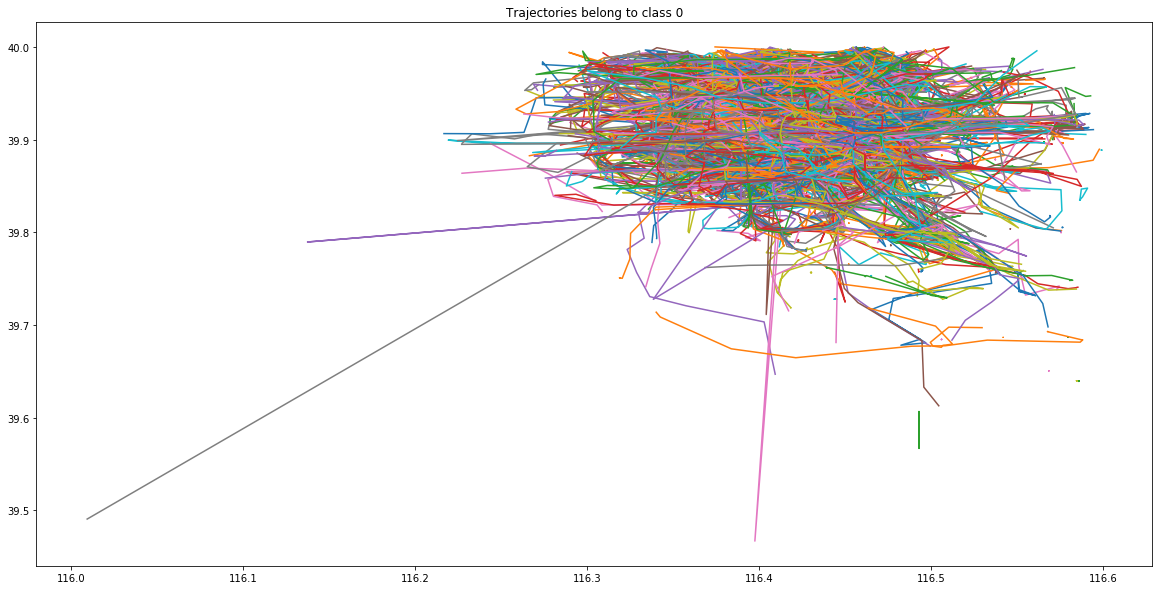

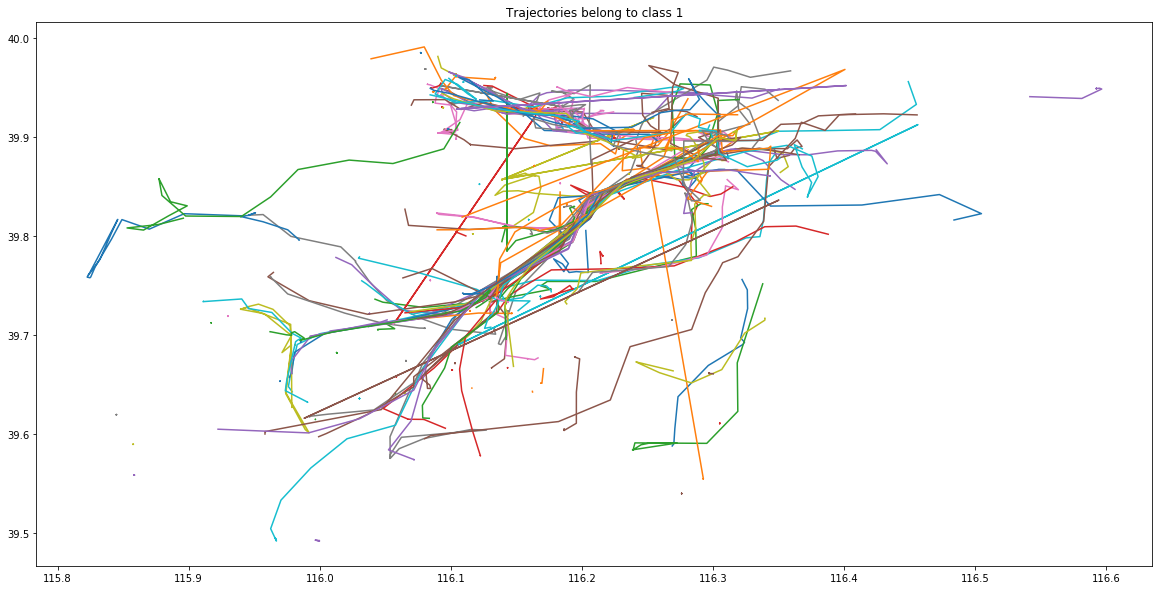

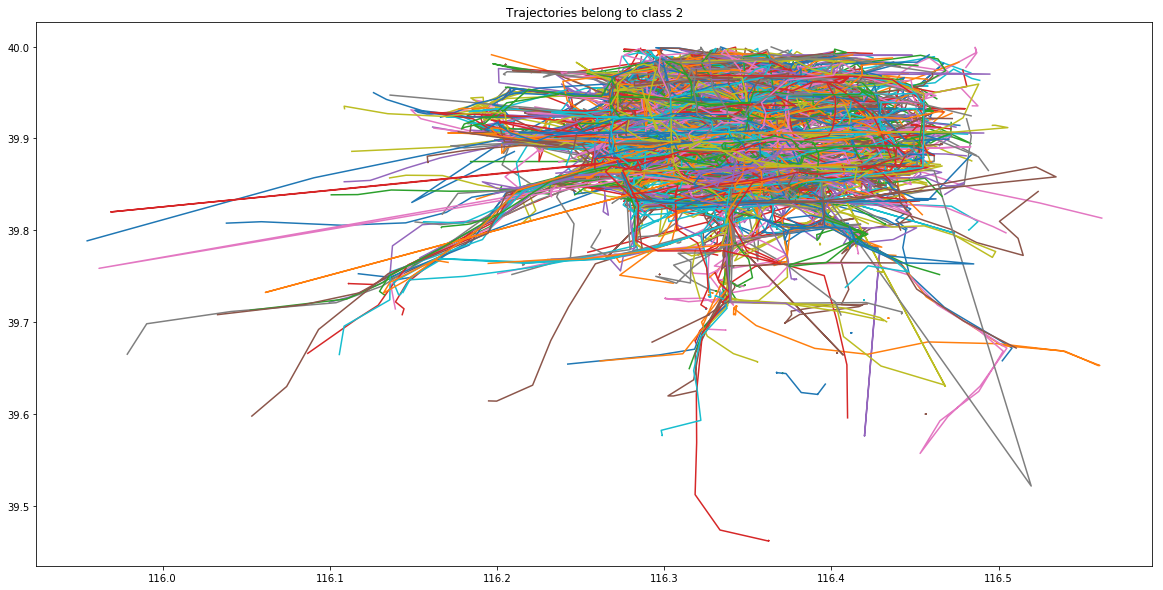

In [0]:
for j in [0,1,2]:
    plt.figure(figsize = (20,10))
    plt.title('Trajectories belong to class ' + str(j))
    plt.xlabel = 'longtitude'
    plt.ylabel = 'lantitude'
    df_gmm_j = df_gmm[df_gmm['gmm_label'] == j]
    trip_j = np.unique(df_gmm_j['trip_id'])
    for k in trip_j:
        x_j = np.array(df_gmm_j.x[df_gmm_j['trip_id'] == k])
        y_j = np.array(df_gmm_j.y[df_gmm_j['trip_id'] == k])
        plt.plot(x_j,y_j)
    plt.show()

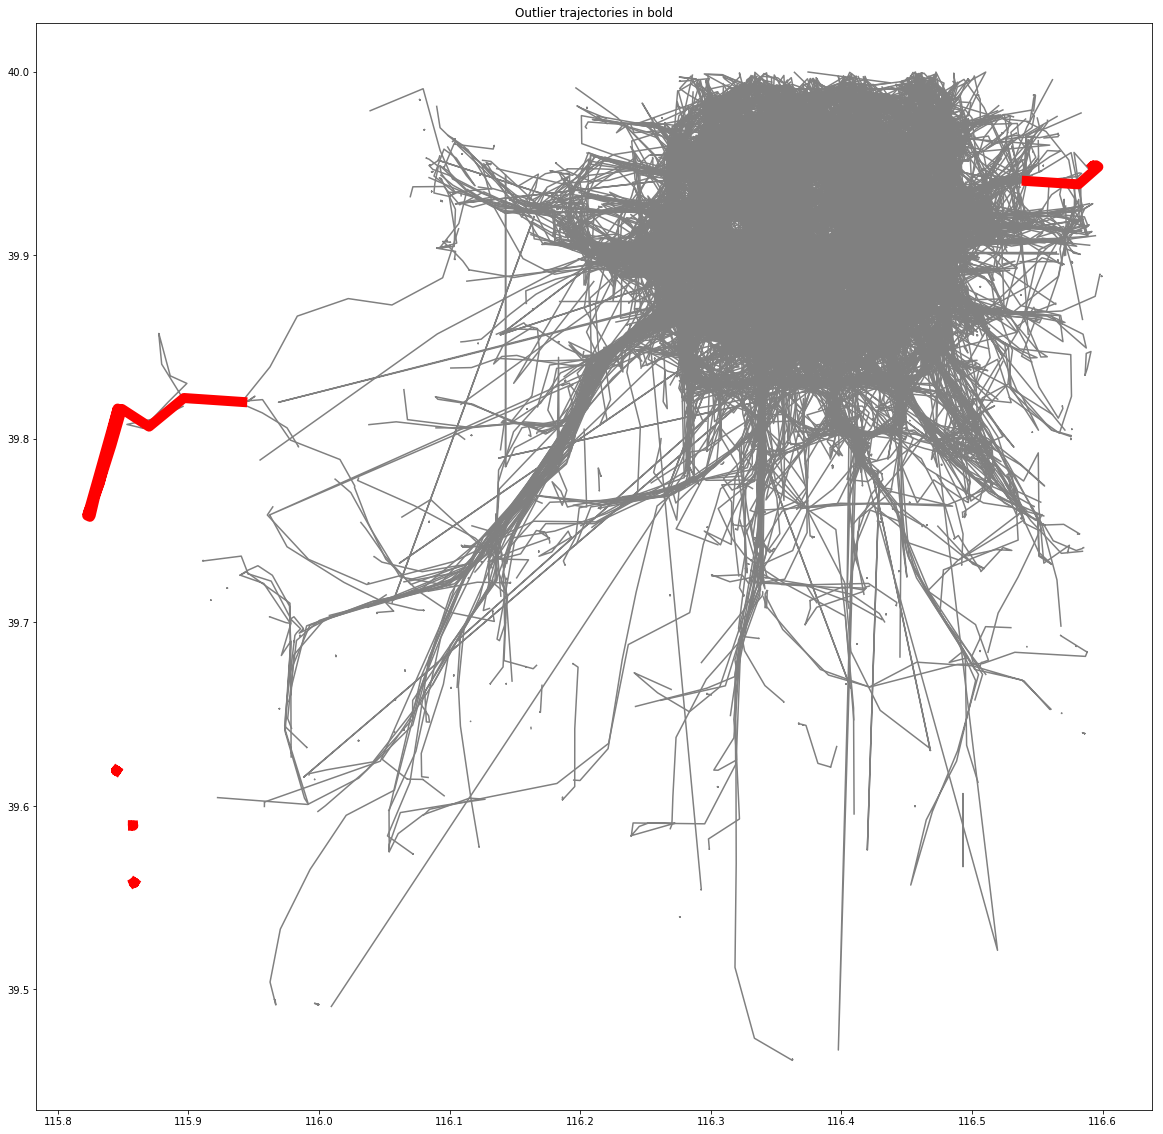

In [0]:
plt.figure(figsize = (20,20))
plt.title('Outlier trajectories in bold')
plt.xlabel = 'longtitude'
plt.ylabel = 'lantitude'
df_major = df_gmm[df_gmm['likelihood'] > 0.002]
df_minor = df_gmm[df_gmm['likelihood'] < 0.002]
trip_major = np.unique(df_major['trip_id'])
trip_minor = np.unique(df_minor['trip_id'])
for m in trip_major:
    x_m = np.array(df_major.x[df_major['trip_id'] == m])
    y_m = np.array(df_major.y[df_major['trip_id'] == m])
    plt.plot(x_m,y_m,color = 'grey')
for n in trip_minor:
    x_n = np.array(df_minor.x[df_minor['trip_id'] == n])
    y_n = np.array(df_minor.y[df_minor['trip_id'] == n])
    plt.plot(x_n,y_n,color = 'r',linewidth = 10)
plt.show()

# 4. Discussion:
**Time consuming parts:** 
The uniform timescale; Read through papers about how to fit our data into the K-Means model.

**Attempts to accelerate time performance**
1. Using sklearn.MiniBatchKMeans instead of Kmeans. 
The difference is that, in mini-batch k-means, the most computationally costly step is conducted on only a random sample of observations as opposed to all observations. This approach can significantly reduce the time required for the algorithm to find convergence (i.e. fit the data) with only a small cost in quality. Through experiments, we found that MinibatchKMeans gives the same parameter result as KMeans, while it's much faster than KMeans.
 

2. Using sklearn.pipeline.Pipeline to select optimal parameters in 2.2.
Pipeline gives us a single interface for all 3 steps of transformation and resulting classifier. Usually GridSearchCV is used for parameter search, but it's designed for supervised learning, so we won't use it in our task here.


**Limitations of K-means**
1. Lack of probabilistic cluster assignment: 
K-means clusters without considering uncertainty. If used K-means directly, we won't be able to tell a trajectory's likelihood of belonging to other clusters.

2. Lack of flexibility: 
K-Means places a circle (or hyper-spehere at high dimension) at the center of each cluster. But sometimes clusters in real-world data are not circular, thus applying K-means directly might result in a poor fit. In the meantime, GMM is capable of finding a smooth Gaussian model rather than a hard-edged sphere.


**Limitations of the current appoarch**
1. Applying PCA to scale the features might make it hard to explain our result. 

2. In this task we basicly rely on euclidean distances to measure the similarity. However, this method strictly calculate the distance in each checkpoints. Thus it's very sensitive to noise.


**Alternative approaches**
1. Partiion trajectories into sub-trajecotries, and each of them is represented by a Minimum Bounding Rectangle(MBR), which is an expression of the maximum extents of a 2-dimensional object. The query processing is then based on these MBRs, instead of scanning data elements of an entire trajectory.(Lee S, Chun S, Kim D, et al.,2000)


2. Longest common sub-sequence, LCSS.(M. Vlachos, G. Kollios, and D. Gunopulos,2002)

This method is robust to noise. Furthermore it provides an intuitive notion of similarity between trajectories by giving more weight to the similar portions of the sequences.
Let A and B be two trajectories of moving objects with size n and m respectively, where A = (($a_{x,1}$,$a_{y,1}$), ..., ($a_{x,n}$,$a_{y,n}$)) and B = (($b_{x,1}$,$b_{y,1}$), ..., ($b_{x,m}$,$b_{y,m}$)). For a trajectory A, let Head(A) be the sequence Head(A) = (($a_{x,1}$,$a_{y,1}$), ..., ($a_{x,n-1}$,$a_{y,n-1}$))

Given an integer $\delta$ and a real number 0<$\epsilon$<1,the definition of $LCSS_{\delta, \epsilon}(A,B)$ is:

\begin{cases}
0, if A or B is empty \\
1 + LCSS_{\delta, \epsilon}(Head(A),Head(B)), if |a_{x,n} - b_{x,m}| < \epsilon, and |a_{y,n}-b_{y,m}| < \epsilon, and |n-m| <= \delta \\
max(LCSS_{\delta, \epsilon}(Head(A),B),LCSS_{\delta, \epsilon}(A,Head(B))), otherwise \\
\end{cases}

The constant $\delta$ controls how far in time we can go in order to match a given point from one trajectory to a point in another trajectory. The constant $\epsilon$ is the matching threshold.

The first similarity function is based on the LCSS and the idea is to allow time streching. Then, objects that are close in space at different time instants can be matched if the time instants are also close.

Then we define the similarity function S1 between two trajectories A and B, given $\delta$ and $\epsilon$, as follow:
\begin{align}
    S1(\delta, \epsilon, A, B) = \frac{LCSS_{\delta, \epsilon}(A,B)}{min(n,m)}
\end{align}
We use this function to define another similarity measure that is more suitable for trajectories. First, we consider the set of translations. A translation simply shifts a trajectory in space by a different constant in each dimension. Let F be the family of translations. Then a function $f_{c,d}$ belongs to F if $f_{c,d}(A) = ((a_{x,1}+ c, a_{y,1}+d)), ..., (a_{x,n}+c,a_{y,n}+d)$. Next, we define a second notion of the similarity based on the above family of functions.

Given \delta , \epsilon and the family F of translations, we define the similarity function S2 between two trajectories A and B , as follows:
\begin{align}
S2(\delta,\epsilon, A, B) = \max\limits_{f_{c,d}\in F} S1(\delta, \epsilon, A, B)
\end{align}
So the similarity functions S1 and S2 range from 0 to 1. Therefore we can define the distance function between two trajectories as follows:
\begin{align}
D1(\delta, \epsilon, A, B) = 1 - S1(\delta, \epsilon, A, B) \\
D2(\delta, \epsilon, A, B) = 1 - S2(\delta, \epsilon, A, B)
\end{align}
By allowing translations, we can detect similarities between movements that are parallel in space, but not identical.